# BigchainDB

In [ ]:
print("Decentralized AI ")

# BigchainDB :
BigchainDB is a scalable blockchain database. It has both the properties of the blockchain (e.g. decentralization, immutability, owner controlled assets) and that of a distributed database (e.g. scalability, queryablity).

In a blockchain platform such as ethereum since a smart contract can store a maximum data of around 1.46 GB and storing large data also incurs a large transaction fee there has always been a need for an external database and bigchainDB fills that gap. Additionally, bigchainDB can also be seamlessly integrated into traditional application stack as a blockchain database for decentralized timestamping, certificates, smart contracts and transactions.

# Transactional model of BigchainDB :
The first and foremost thing to understand is how the data is structured in the database. 

Traditionally,

* SQL databases structure the data in the form ofn **tables,** 

* NoSQL uses other formats to structure the data using other forms such as **JSON and key-value,** as well as a **table.** 

* BigchainDB data is structured as **assets.** 

An asset can represent any physical object like a car or a house. Or it can any digital object such as a customer object.

Assets are the immutable part of the transaction. These assets can be registered on BigchainDB in two ways:

* By users in the CREATE transaction.
* Transfer or Updated to other users in the TRANSFER transaction.

Each asset can have metadata associated with it. Metadata is mutable, the information in metadata can be updated in the future transactions. A transaction has two other components i.e.: input and output which will be further explained in the later part. After a transaction is processed, a transaction id is generated. The transaction id is the hash of all the information contained in the transaction, it is used to create references to that transaction in future transactions.

In addition to this, this is also a concept of spent and unspent transaction which I will be elaborating when I will demonstrate the Retrieve operation.

#  Basic Operations

BigchainDB provides two main methods through which we can communicate with the bigchainDB network (set of nodes) one of them being is using BigchainDB HTTP API or a wrapper for that API, such as BigchainDB Python Driver or the BigchainDB JavaScript Driver. In this case, we will be moving forward with the JavaScript Driver. Traditional databases involve CRUD (Create, Retrieve, Update and Delete) operations, but in this case, the bigchainDB has CRAB (Create, Retrieve, Append and Burn) operations and in addition to this, there is a transfer operation as mentioned before.

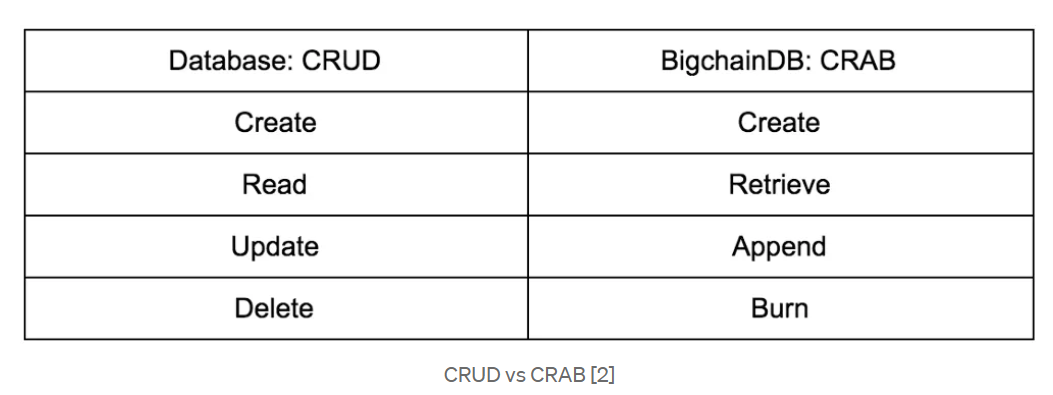

# Installation and establishing a connection

In [ ]:
$ npm install bigchaindb-driver

We begin by importing the BigchainDB driver:

In [ ]:
const driver = require('bigchaindb-driver')

Next, we define a constant containing the API path. In this case, I am directly connecting with the BigchainDB testnet.

In [ ]:
const API_PATH = 'https://test.bigchaindb.com/api/v1/'

A simple connection with a BigchainDB node can be established like this:

In [ ]:
const conn = new driver.Connection(API_PATH)

# Asset Creation ( Create Operation )
Each user is represented by a set of public/private key pair. The private key is used to sign that transaction, while the public key is used to verify that a signed transaction was indeed signed by the user who claims to be the signee. This public/private key pair can be generated as follows:

In [ ]:
const alice = new driver.Ed25519Keypair()

Let’s create an asset representing a car

In [ ]:
const assetdata = {
        'car': {
                'serial_number': 'AB70CD7695',
                'manufacturer': 'XYZ Inc.',
        }
}

Optionally, we can also give some metadata to this asset as follows:

Now, let’s make a create transaction:

In [ ]:
const assetCreateTx = driver.Transaction.makeCreateTransaction(
        assetdata,
        metadata,
       // Every transaction which you make requires an output
        [ driver.Transaction.makeOutput( driver.Transaction.makeEd25519Condition(alice.publicKey))
        ],
        alice.publicKey
)

A transaction always needs an array of Output objects. Each output indicates the crypto-conditions which must be satisfied by anyone wishing to spend/transfer that output. It also indicates the number of shares of the asset tied to that output. In case of a create transaction, this should usually just be a list of Outputs wrapping Ed25519 Conditions generated from the issuers’ public keys (so that the issuers are the recipients of the created asset).[1]

In this case, alice.publicKey is the input of the transaction. Each input spends/transfer the Output by satisfying the crypto-condition on that output.

Transaction inputs and outputs are the mechanisms by which control or ownership of an asset (or shares of an asset) is transferred.

Sign the transaction with the private key of Alice to complete it and send it over to a BigchainDB node.

In [ ]:
const assetCreateTxSigned = driver.Transaction.signTransaction(assetCreateTx, alice.privateKey)
conn.postTransactionCommit(assetCreateTxSigned)

We can retrieve the transaction id as follows:

In [ ]:
txid = assetCreateTxSigned.id

# Asset Transfer (Transfer Operation)
Imagine the car which Alice created previously now wants to sell this car to Bob. In order to transfer the asset (car) to Bob, Alice must consume the transaction’s output in which the car was created.[1]

Alice could retrieve the transaction as:

In [ ]:
conn.getTransaction(assetCreateTxSigned.id)

Now, let us prepare the transaction to be transferred:

In [ ]:
const txTransferBob = driver.Transaction.makeTransferTransaction(
        [{ tx: assetCreateTxSigned, output_index: 0 }],
        [driver.Transaction.makeOutput(driver.Transaction.makeEd25519Condition(bob.publicKey))],
);

The function makeTransferTransaction() needs the following parameters[1] :

* Unspent outputs: Array of unspent transactions outputs
* An array of output objects to add to the transaction
* Metadata for the transaction (optional)
Now, sign the transaction with the private key of Alice to fulfill it and send it over to a BigchainDB node as shown previously.

**Append Operation**
As mentioned before each asset can have metadata associated with it which is the mutable part. One can add new data to the metadata and also modify the pre-existing data. In order to modify the pre-existing data, one should keep the same key with the modified value part.

Note that underlying the append/update function is represented by a TRANSFERtransaction to the same owner.

Now, let’s add another parameter to the previously created car asset and modified the existing fule parameter.

In [ ]:
const metadata = {
'fuel_level': '75',
'colour':'Blue'
}

Let us now prepare the transaction:

In [ ]:
const appendTransaction = driver.Transaction.makeTransferTransaction(
[{ tx: assetCreateTxSigned, output_index: 0 }],[driver.Transaction.makeOutput(
driver.Transaction.makeEd25519Condition(alice.publicKey)],
//modified metadata
metadata
);

Now, sign the transaction with the private key of Alice to fulfill it and send it over to a BigchainDB node as shown previously.

# Burn Operation
As stated previously, an asset is immutable and hence cannot be deleted. However, we can transfer the asset to an unspendable public key hence preventing anyone to transfer it any further. We generated an artificial public key that looks like this: BurnBurnBurnBurnBurnBurnBurnBurnBurnBurnBurn.

Let’s prepare the transaction: